In [2]:
# generic import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# mne import
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
# from mne.decoding import CSP

# pyriemann import
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances
from pyriemann.spatialfilters import CSP
from pyriemann.utils.viz import plot_embedding

# sklearn imports
from sklearn.model_selection import cross_val_score, KFold,RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## 画下几种embedding

ok


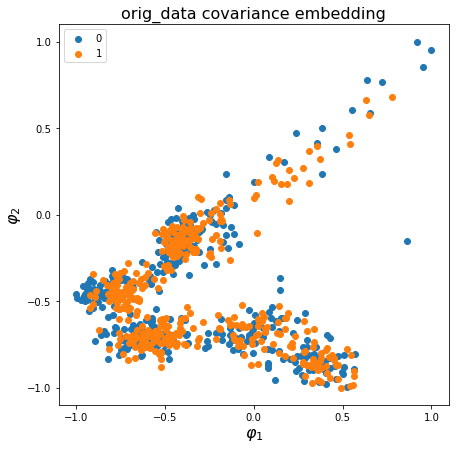

In [5]:
data = np.load('data/train/data.npz')

epochs_data_train = data['X']
labels = data['y']

# compute covariance matrices
cov_data_train = Covariances().transform(epochs_data_train)

plot_embedding(X=cov_data_train,y=labels,title='orig_data covariance embedding')
print('ok')

ok


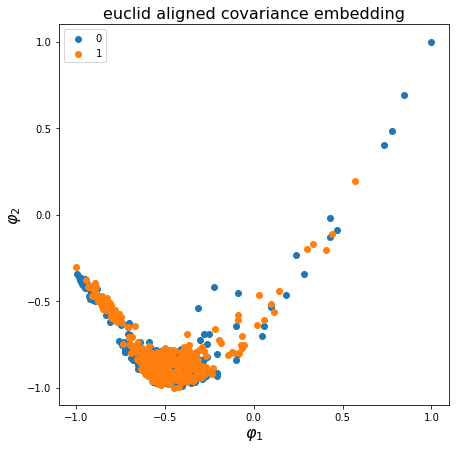

In [6]:
data = np.load('data/train/ea_data.npz')

epochs_data_train = data['X']
labels = data['y']

# compute covariance matrices
cov_data_train = Covariances().transform(epochs_data_train)

plot_embedding(X=cov_data_train,y=labels,title='euclid aligned covariance embedding')
print('ok')

ok


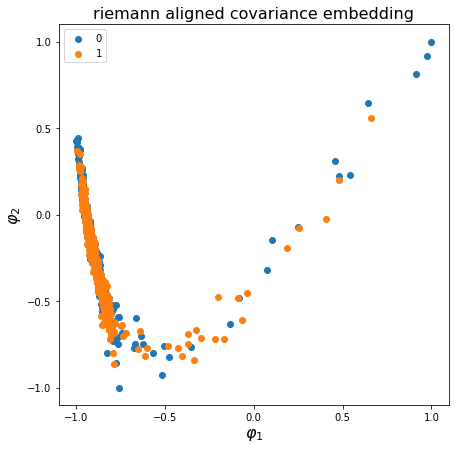

In [24]:
data = np.load('data/train/ra_data.npz')

epochs_data_train = data['X']
labels = data['y']

# compute covariance matrices
cov_data_train = Covariances().transform(epochs_data_train)

plot_embedding(X=cov_data_train,y=labels,title='riemann aligned covariance embedding')
print('ok')

## 画下平均波形图

In [17]:
# just a copy from the package github code, because I don't have this function in my package for unknown reason(maybe the version problem)
def plot_waveforms(X, display, *, times=None, color='gray', alpha=0.5,
                   linewidth=1.5, color_mean='k', color_std='gray', n_bins=50,
                   cmap=None):
    """ Display repetitions of a multichannel waveform.
    Parameters
    ----------
    X : ndarray, shape (n_reps, n_channels, n_times)
        Repetitions of the multichannel waveform.
    display : {'all', 'mean', 'mean+/-std', 'hist'}
        Type of display:
        * 'all' for all the repetitions;
        * 'mean' for the mean of the repetitions;
        * 'mean+/-std' for the mean +/- standard deviation of the repetitions;
        * 'hist' for the 2D histogram of the repetitions.
    time : None | ndarray, shape (n_times,) (default None)
        Values to display on x-axis.
    color : matplotlib color, optional
        Color of the lines, when ``display=all``.
    alpha : float, optional
        Alpha value used to cumulate repetitions, when ``display=all``.
    linewidth : float, optional
        Line width in points, when ``display=mean``.
    color_mean : matplotlib color, optional
        Color of the mean line, when ``display=mean``.
    color_std : matplotlib color, optional
        Color of the standard deviation area, when ``display=mean+/-std``.
    n_bins : int, optional
        Number of vertical bins for the 2D histogram, when ``display=hist``.
    cmap : Colormap or str, optional
        Color map for the histogram, when ``display=hist``.
    Returns
    -------
    fig : matplotlib figure
        Figure of waveform (one subplot by channel).
    Notes
    -----
    .. versionadded:: 0.2.8
    """
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Install matplotlib to plot waveforms")

    if X.ndim != 3:
        raise Exception('Input X has not 3 dimensions')
    n_reps, n_channels, n_times = X.shape
    if times is None:
        times = np.arange(n_times)
    elif times.shape != (n_times,):
        raise Exception(
            'Parameter times has not the same number of values as X')

    fig, axes = plt.subplots(nrows=n_channels, ncols=1)
    if n_channels == 1:
        axes = [axes]
    channels = np.arange(n_channels)

    if display == 'all':
        for (channel, ax) in zip(channels, axes):
            for i_rep in range(n_reps):
                ax.plot(times, X[i_rep, channel], c=color, alpha=alpha)

    elif display in ['mean', 'mean+/-std']:
        mean = np.mean(X, axis=0)
        for (channel, ax) in zip(channels, axes):
            ax.plot(times, mean[channel], c=color_mean, lw=linewidth)
            ax.set_yticks([])  # remove yticklabels I only modified this
        if display == 'mean+/-std':
            std = np.std(X, axis=0)
            for (channel, ax) in zip(channels, axes):
                ax.fill_between(times, mean[channel] - std[channel],
                                mean[channel] + std[channel], color=color_std)

    elif display == 'hist':
        times_rep = np.repeat(times[np.newaxis, :], n_reps, axis=0)
        for (channel, ax) in zip(channels, axes):
            ax.hist2d(times_rep.ravel(), X[:, channel, :].ravel(),
                      bins=(n_times, n_bins), cmap=cmap)

    else:
        raise Exception('Parameter display unknown %s' % display)

    if n_channels > 1:
        for ax in axes[:-1]:
            ax.set_xticklabels([])  # remove xticklabels
    return fig

ok


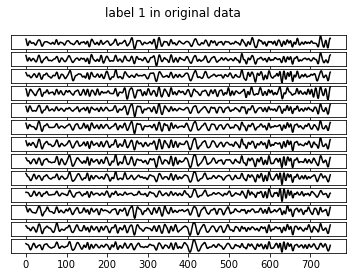

In [26]:
X = np.load('data/train/data.npz')['X']
y = np.load('data/train/data.npz')['y']
fig = plot_waveforms(X[y==1],display='mean')
fig.suptitle('label 1 in original data')
print('ok')

ok


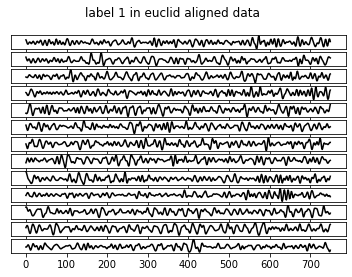

In [22]:
X = np.load('data/train/ea_data.npz')['X']
y = np.load('data/train/ea_data.npz')['y']
fig = plot_waveforms(X[y==1],display='mean')
fig.suptitle('label 1 in euclid aligned data')
print('ok')

ok


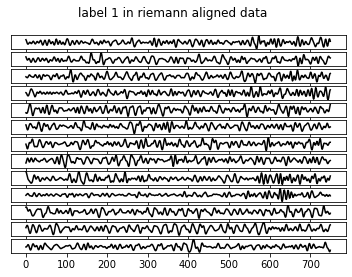

In [23]:
X = np.load('data/train/ra_data.npz')['X']
y = np.load('data/train/ra_data.npz')['y']
fig = plot_waveforms(X[y==1],display='mean')
fig.suptitle('label 1 in riemann aligned data')
print('ok')

## 画一下各个人的波形做下比较

In [12]:
X1=np.load('data/train/S1.npz')['X']
y1=np.load('data/train/S1.npz')['y']
X2=np.load('data/train/S2.npz')['X']
y2=np.load('data/train/S2.npz')['y']
X3=np.load('data/train/S3.npz')['X']
y3=np.load('data/train/S3.npz')['y']


ok


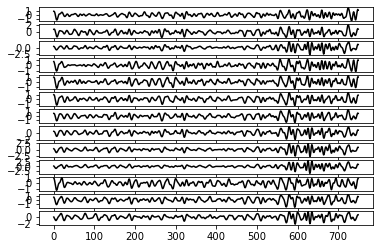

In [8]:
plot_waveforms(X1[y1==1],display='mean')
print('ok')

ok


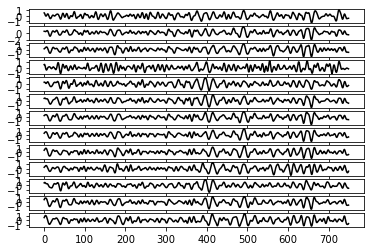

In [11]:
plot_waveforms(X2[y2==1],display='mean')
print('ok')

ok


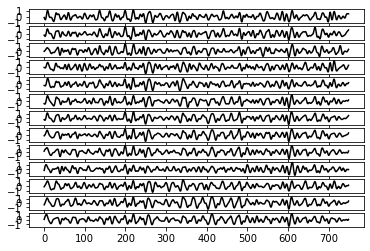

In [13]:
plot_waveforms(X3[y3==1],display='mean')
print('ok')

ok


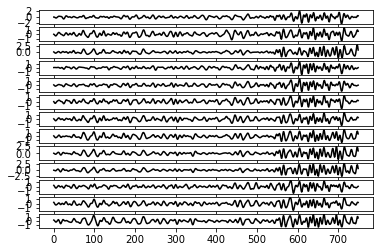

In [9]:
plot_waveforms(X1[y1==0],display='mean')
print('ok')

## 绘制结果比较图

In [3]:
import seaborn as sns

In [25]:
d = {
    'orig':{'TS+LDA':0.59,'CSP+SVM':0.63,'FBCSP+SVM':0.65,'BrainNetv1':0.61,'BrainNetv2':0.49,'BrainNetv3':0.52},
    'ea':{'TS+LDA':0.57,'CSP+SVM':0.62,'FBCSP+SVM':0.63,'BrainNetv1':0.62,'BrainNetv2':0.52,'BrainNetv3':0.55},
    'ra':{'TS+LDA':0.58,'CSP+SVM':0.61,'FBCSP+SVM':0.64,'BrainNetv1':0.61,'BrainNetv2':0.53,'BrainNetv3':0.54}
}
res_ = pd.DataFrame.from_dict(d,orient='index').reset_index()
res_

,index,TS+LDA,CSP+SVM,FBCSP+SVM,BrainNetv1,BrainNetv2,BrainNetv3
0,orig,0.59,0.63,0.65,0.61,0.49,0.52
1,ea,0.57,0.62,0.63,0.62,0.52,0.55
2,ra,0.58,0.61,0.64,0.61,0.53,0.54


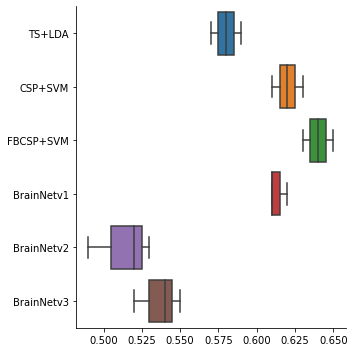

In [27]:
pic = sns.catplot(data=res_,kind='box',orient='h')
pic.set_titles('method vs accuracy')

In [9]:
data = {
    'method':['TS+LDA','CSP+SVM','FBCSP+SVM','BrainNetv1','BrainNetv2','BrainNetv3']*3,
    'data':['orig']*6+['ea']*6+['ra']*6,
    'accuracy':[0.59,0.63,0.65,0.61,0.49,0.52]+[0.57,0.62,0.63,0.62,0.52,0.55]+[0.58,0.61,0.64,0.61,0.53,0.54]
}
res = pd.DataFrame(data)
res

,method,data,accuracy
0,TS+LDA,orig,0.59
1,CSP+SVM,orig,0.63
2,FBCSP+SVM,orig,0.65
3,BrainNetv1,orig,0.61
4,BrainNetv2,orig,0.49
5,BrainNetv3,orig,0.52
6,TS+LDA,ea,0.57
7,CSP+SVM,ea,0.62
8,FBCSP+SVM,ea,0.63
9,BrainNetv1,ea,0.62


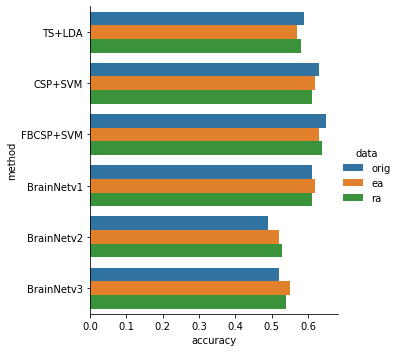

In [18]:
sns.catplot(x='accuracy',y='method',hue='data',kind='bar',data=res)